### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [6]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [7]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


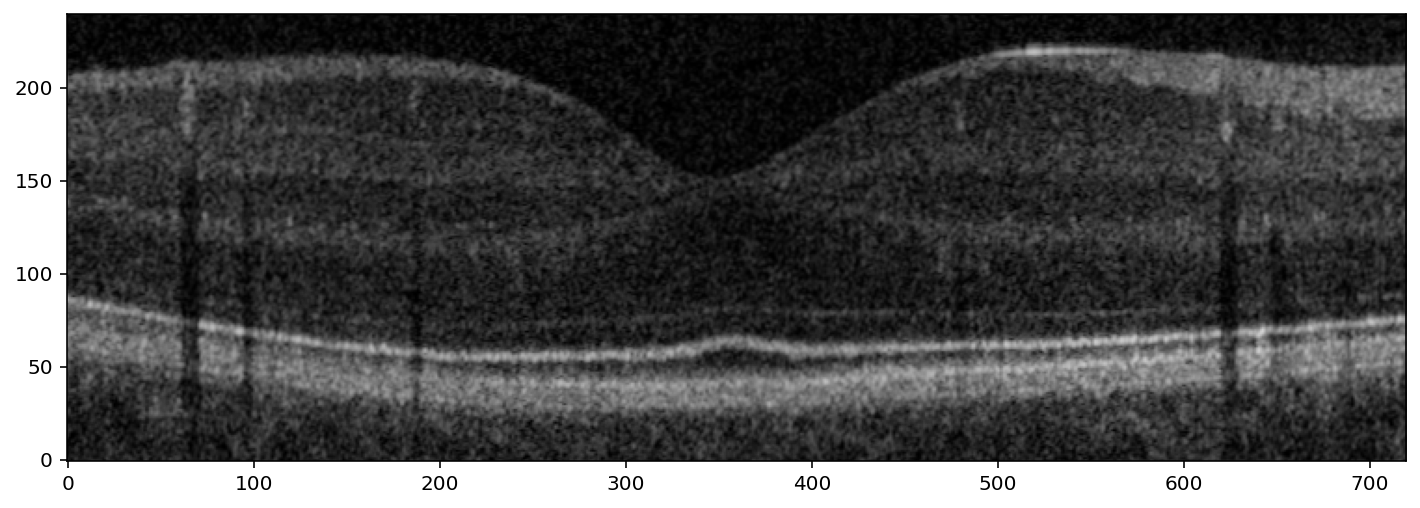

In [8]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [9]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        # Your existing __init__ method here
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta + self.dgamma), self.y + self.dr * np.sin(self.theta + self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1, p2]))

    def control_points(self):
        return self.bezier.control_points

    def path(self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch(self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points(self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r / 8)))
        return self.bezier.point_at_t(np.linspace(0, 1, intervals))

    def approx_length(self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates, intermediates)
        return np.sum(np.diag(eds, 1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1, 2)))
        colours = [image[point[0], point[1]] for point in intermediates]
        return np.array(colours) / 255

    # Added size and distance_to methods to the camo worm class to return worm size and distance between worms
    def size(self):
        return self.r

    # Distance function calculated using Euclidean distance
    def distance_to(self, other_worm):
        distance = ((self.x - other_worm.x) ** 2 + (self.y - other_worm.y) ** 2) ** 0.5
        return distance


In [10]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [11]:
def random_worm(imshape, init_params):
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = init_params[0] * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = init_params[1] * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = init_params[2] * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

In [12]:
#Cost Functions

def distance_constraint(new_worm, existing_worms):
    for worm in existing_worms:
        if new_worm.distance_to(worm) < 20:
            return False
    return True


def size_constraint(new_worm):
    return new_worm.size() > 10

In [17]:
def initialise_clew(size, imshape, init_params):
    clew = []
    while True:
        new_worm = random_worm(imshape, init_params)
        #Checks if generated worms fulfills the requirements of the cost function
        if distance_constraint(new_worm, clew) and size_constraint(new_worm): 
            clew.append(new_worm)
            if len(clew) == size:
                return clew

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


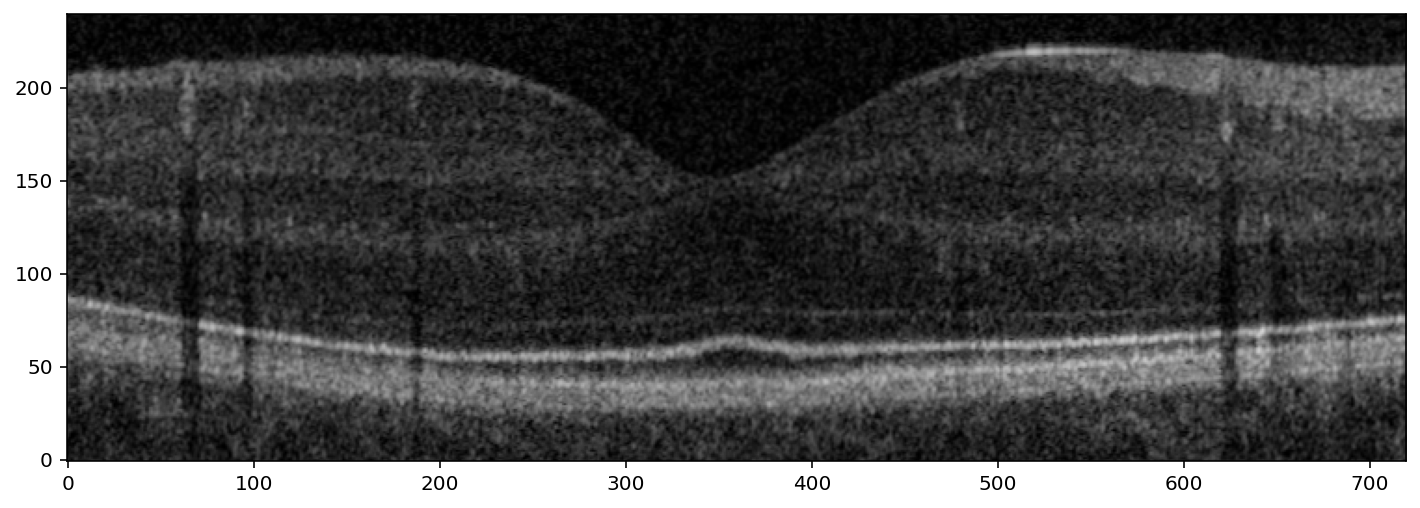

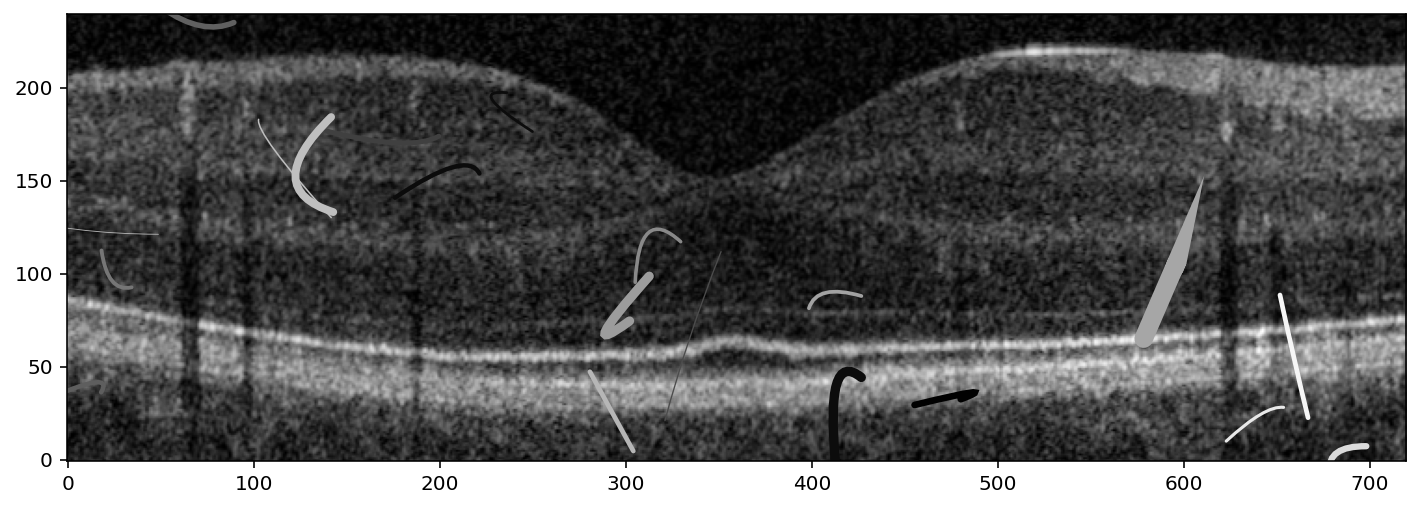

In [18]:
# Initialise clew and draw
image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# Can change the number of worms, if functions keeps on running, try to modify this or the threshold as we might be trying to generate more worms than possible 
clew = initialise_clew(20, image.shape, (20, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

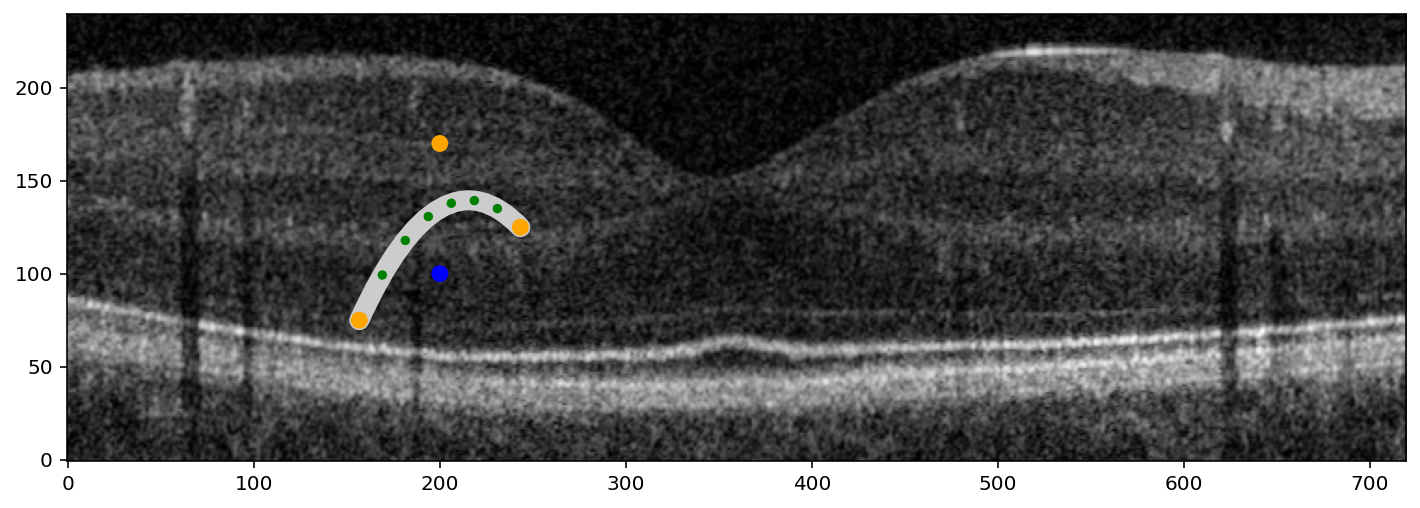

In [28]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

&copy; Cara MacNish, UWA, 2024